In [1]:
import csv
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from matplotlib import font_manager
from collections import Counter
from pyecharts.charts import Line, Bar, Pie, TreeMap
from pyecharts import options as opts 

In [2]:
# 解决matplotlib 无法显示中文的问题
my_font = font_manager.FontProperties(fname='/System/Library/Fonts/PingFang.ttc',size=18)

In [3]:
data = pd.read_csv('data/data.csv',low_memory=False)

### 数据分析

在这次分析过程中,我们将使用RFM模型   
通过一个客户的近期购买行为,购买的总体频率以及花了多少钱三项指标来描述该客户的价值状况  
R：最近一次消费时间(最近一次消费到参考时间的间隔)   
F：消费的频率(消费了多少次)  
M：消费的金额(总消费金额)    

In [4]:
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
37356,539595,22728,ALARM CLOCK BAKELIKE PINK,1,2010-12-20 13:43:00,7.62,0.0,United Kingdom,7.62
356084,568894,22158,3 HEARTS HANGING DECORATION RUSTIC,2,2011-09-29 13:04:00,2.95,17528.0,United Kingdom,5.90
451394,576321,22585,PACK OF 6 BIRDY GIFT TAGS,1,2011-11-14 14:59:00,1.25,14953.0,United Kingdom,1.25
103779,545416,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,48,2011-03-02 13:35:00,0.85,17770.0,United Kingdom,40.80
177864,552671,20718,RED RETROSPOT SHOPPER BAG,1,2011-05-10 15:06:00,3.29,0.0,United Kingdom,3.29


In [5]:
len(data['CustomerID'].unique())

4339

In [6]:
len(data['InvoiceNo'].unique())

19960

统计区间(2010年12月1日-2011年12月9日)内共产生有效订单19960笔,客户数4338个(不包含CustomerID为0的客户)

#### 按分析目的,对数据进行分类汇总：

In [7]:
# 把日期转换为datetime格式 用于计算与指定时间的天数差
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.strftime('%Y-%m-%d')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data_new = pd.to_datetime('2011-12-09')

In [8]:
# 根据原有数据计算出 天数差
data['date_diff'] = (data_new - data['InvoiceDate']).dt.days

#### 根据用户ID分组,统计最近一次消费时间,消费的频率(交易次数),交易金额

In [9]:
def unique_count(x):
    return len(x.unique())

In [10]:
df_result = data.groupby('CustomerID').agg({'date_diff':'min','Amount':'sum','InvoiceNo':unique_count})
df_result.sort_values(by=['date_diff'],axis=0,ascending=False,inplace=True)
df_result.reset_index(inplace=True)

In [11]:
# 对交易金额四舍五入,重新命名数据列名方便理解
df_result['Amount'] = df_result['Amount'].round()
df_result.rename(columns={'date_diff': '天数差','Amount':'交易金额','InvoiceNo':'交易次数'},inplace=True)

In [12]:
df_result.head(5)

,CustomerID,天数差,交易金额,交易次数
0,15165.0,373,488.0,1
1,17908.0,373,232.0,1
2,16583.0,373,233.0,1
3,14142.0,373,312.0,1
4,15922.0,373,370.0,1


In [13]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 4 columns):
CustomerID    4339 non-null float64
天数差           4339 non-null int64
交易金额          4339 non-null float64
交易次数          4339 non-null int64
dtypes: float64(2), int64(2)
memory usage: 135.7 KB


#### 客户购买周期可视化

Text(0.5, 1.0, '客户购买周期')

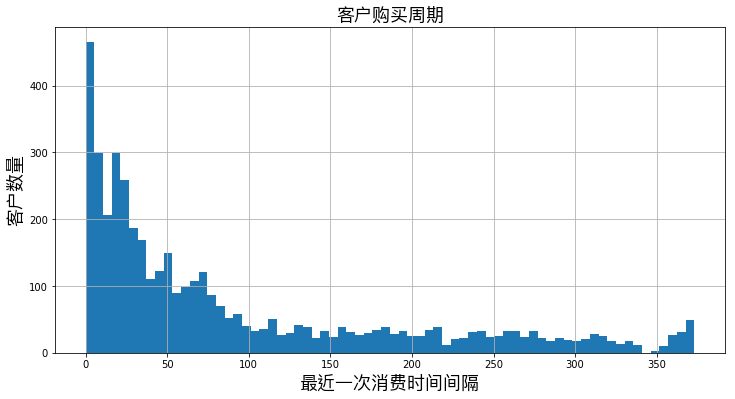

In [14]:
df_result['天数差'].hist(bins=70,figsize=(12,6))
plt.ylabel('客户数量',fontsize='12', fontproperties=my_font)
plt.xlabel('最近一次消费时间间隔',fontsize='12', fontproperties=my_font)
plt.title('客户购买周期',fontsize=16, fontproperties=my_font)

In [15]:
a = df_result[df_result['天数差']<=180].shape[0]
b = df_result.shape[0]
print('客户购买周期,最长373天,最短0天,{}%的客户都会在180天内发生交易行为'.format(round(a/b*100,2)))

客户购买周期,最长373天,最短0天,80.23%的客户都会在180天内发生交易行为


#### 交易频率可视化

In [16]:
data1 = df_result.groupby(['交易次数'])['CustomerID'].count()
x = data1.values 
y = data1.index

Text(0.5, 1.0, '交易频率')

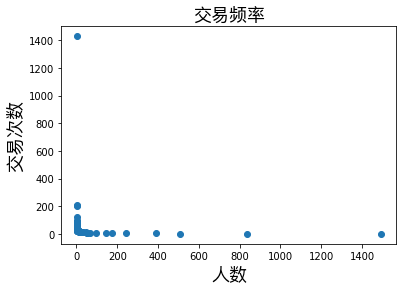

In [17]:
plt.scatter(x,y)
plt.ylabel('交易次数',fontsize=12, fontproperties=my_font)
plt.xlabel('人数',fontsize=12, fontproperties=my_font)
plt.title('交易频率',fontsize=16, fontproperties=my_font)

In [18]:
# 只交易了一次的人数
a = data1[data1.index==1].values[0]
# 所有的用户数
b = len(data['CustomerID'].unique())
# 复购率
p = round(((b-a)/b*100),1)

print('只有一次交易记录的共有{0}人,其他{1}%的客户存在复购行为'.format(a,p))

只有一次交易记录的共有1493人,其他65.6%的客户存在复购行为


#### 总消费金额可视化

In [19]:
bins = [0,1000,3000,5000,10000,2000000]

In [20]:
df_result['消费金额区间'] = pd.cut(df_result['交易金额'],bins)

In [21]:
data2 = df_result.groupby(['消费金额区间'])['CustomerID'].count()

In [22]:
p1 = (
        Pie()
        .add("", [list(z) for z in zip(data2.index.astype(str), data2.values.tolist())])
        .set_global_opts(
            title_opts=opts.TitleOpts(title="消费金额分布"),
            legend_opts=opts.LegendOpts(
                orient="vertical", pos_top="15%", pos_left="2%"
            ))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    )
p1.render_notebook()

In [23]:
a = round(2677/4339*100,1)
b = round(1108/4339*100,1)
print('在2010年12月1日到2011年12月9日期间,1000英镑以内和1000-3000英镑这两个区间的消费者比重较高,分别为{}%和{}%'.format(a,b))

在2010年12月1日到2011年12月9日期间,1000英镑以内和1000-3000英镑这两个区间的消费者比重较高,分别为61.7%和25.5%


### RFM评分

根据客户消费的时间间隔(R),消费频率(F)及消费金额(M),制定RFM评分,对客户进行评分

In [24]:
def R_critic(x):
    if x>=0 and x<=30:
        return 5
    elif x>30 and x<=90:
        return 4
    elif x>90 and x<=180:
        return 3
    elif x>180 and x<=365:
        return 2
    else:
        return 1

In [25]:
def F_critic(x):
    if x>=0 and x<=10:
        return 1
    elif x>10 and x<=30:
        return 2
    elif x>30 and x<=50:
        return 3
    elif x>50 and x<=80:
        return 4
    else:
        return 5

In [26]:
def M_critic(x):
    if x>=0 and x<=1000:
        return 1
    elif x>1000 and x<=3000:
        return 2
    elif x>3000 and x<=5000:
        return 3
    elif x>5000 and x<=10000:
        return 4
    else:
        return 5

In [27]:
df_result['R评分'] = df_result['天数差'].apply(lambda x: R_critic(x))
df_result['F评分'] = df_result['交易次数'].apply(lambda x: F_critic(x))
df_result['M评分'] = df_result['交易金额'].apply(lambda x: M_critic(x))

In [28]:
df_result.head(10)

,CustomerID,天数差,交易金额,交易次数,消费金额区间,R评分,F评分,M评分
0,15165.0,373,488.0,1,"(0, 1000]",1,1,1
1,17908.0,373,232.0,1,"(0, 1000]",1,1,1
2,16583.0,373,233.0,1,"(0, 1000]",1,1,1
3,14142.0,373,312.0,1,"(0, 1000]",1,1,1
4,15922.0,373,370.0,1,"(0, 1000]",1,1,1
5,16048.0,373,256.0,2,"(0, 1000]",1,1,1
6,13747.0,373,80.0,1,"(0, 1000]",1,1,1
7,18074.0,373,490.0,1,"(0, 1000]",1,1,1
8,17968.0,373,265.0,1,"(0, 1000]",1,1,1
9,15350.0,373,116.0,1,"(0, 1000]",1,1,1


### 客户分层的阈值

RFM评分结束后,计算RFM各自的平均值,将平均值做为客户划分的阈值,再做最后的客户分层处理

In [29]:
# 平均值
round(df_result[['R评分','F评分','M评分']].mean(),2)

R评分    3.84
F评分    1.09
M评分    1.60
dtype: float64

In [30]:
def R_score(x):
    if x>3.84:
        return 1
    else:
        return 0
def F_score(x):
    if x>1.09:
        return 1
    else:
        return 0
def M_score(x):
    if x>1.60:
        return 1
    else:
        return 0

In [31]:
df_result['R值'] = df_result['R评分'].apply(lambda x: R_score(x))
df_result['F值'] = df_result['F评分'].apply(lambda x: F_score(x))
df_result['M值'] = df_result['M评分'].apply(lambda x: M_score(x))

In [32]:
df_result.sample(5)

,CustomerID,天数差,交易金额,交易次数,消费金额区间,R评分,F评分,M评分,R值,F值,M值
1756,18204.0,71,1975.0,3,"(1000, 3000]",4,1,2,1,0,1
1467,14307.0,88,2996.0,6,"(1000, 3000]",4,1,2,1,0,1
142,15346.0,332,252.0,1,"(0, 1000]",2,1,1,0,0,0
2132,15505.0,52,3611.0,5,"(3000, 5000]",4,1,3,1,0,1
4103,16015.0,3,705.0,3,"(0, 1000]",5,1,1,1,0,0


### 客户分层

根据RFM值,对客户行为进行分层处理（消费金额M处于支柱地位）  

R F M 客户类型   
1 1 1 重要价值客户  
1 0 1 重要发展客户  
0 1 1 重要保持客户  
0 0 1 重要挽留客户  
1 1 0 一般价值用户  
1 0 0 一般发展客户  
0 1 0 一般保持用户  
0 0 0 流失用户  

In [33]:
def diff_user(x,y,z):
    if x==1 and y==1 and z==1:
        return '重要价值客户'
    elif x==1 and y==0 and z==1:
        return '重要发展客户'
    elif x==0 and y==1 and z==1:
        return '重要保持客户'    
    elif x==0 and y==0 and z==1:
        return '重要挽留客户'
    if x==1 and y==1 and z==0:
        return '一般价值客户'
    elif x==1 and y==0 and z==0:
        return '一般发展客户'
    elif x==0 and y==1 and z==0:
        return '一般保持客户'    
    else:
        return '流失客户'

In [34]:
df_result['客户类型'] = df_result.apply(lambda x: diff_user(x.R值,x.F值,x.M值),axis=1)

In [35]:
df_result['客户类型'].value_counts()

一般发展客户    1456
流失客户      1221
重要发展客户    1103
重要价值客户     331
重要挽留客户     221
重要保持客户       7
Name: 客户类型, dtype: int64

In [36]:
index1 = df_result['客户类型'].value_counts().index.tolist()
value1 = df_result['客户类型'].value_counts().values.tolist()

bar1 = (
    Bar()
    .add_xaxis(index1)
    .add_yaxis('人数',value1)
    .set_global_opts(title_opts=opts.TitleOpts(title="客户分层"),
                     yaxis_opts=opts.AxisOpts(name="数量"),
                     xaxis_opts=opts.AxisOpts(name="客户类型"))

)
bar1.render_notebook()

在分层客户数量方面,一般发展客户,最近有交易的新客户最多,占总数的33.6%;  
其次是流失客户28.1%,重要发展客户25.4%,重要价值客户7.6%,重要挽留客户5.1%和重要保持客户0.2%

In [37]:
data3 = df_result.groupby(['客户类型'])['交易金额'].sum()

In [38]:
p2 = (
        Pie()
        .add("", [list(z) for z in zip(data3.index.astype(str), data3.values.tolist())])
        .set_global_opts(
            title_opts=opts.TitleOpts(title="各层交易金额占比"),
            legend_opts=opts.LegendOpts(
                orient="vertical", pos_top="15%", pos_left="2%"
            ))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    )
p2.render_notebook()

在分层客户贡献度方面,贡献最高的是重要价值客户,交易额6,112,314英镑,占总交易额的57.5%;   
其次是重要发展客户,交易金额2,817,183英镑,占总交易额的26.5%;  
这两类客户贡献度高达83.9%,符合二八原则

### 区位维度分析

#### 分析流失客户区域

In [84]:
df3 = df_result[df_result['客户类型']=='流失客户']
df4 = df3[['CustomerID','交易金额']]

In [88]:
df5 = pd.merge(df4,data[['Country','CustomerID']],on='CustomerID',how='left')

In [102]:
result = df5.groupby(['Country']).apply(lambda x: len(x.CustomerID.unique()))

In [103]:
result.sort_values(ascending=False,inplace=True)

In [107]:
index6 = result.index.tolist()
value6 = result.values.tolist()

bar4 = (
    Bar()
    .add_xaxis(index6)
    .add_yaxis('人数',value6)
    .set_global_opts(title_opts=opts.TitleOpts(title="客户分层"),
                     yaxis_opts=opts.AxisOpts(name="数量"),
                     xaxis_opts=opts.AxisOpts(name="客户类型",axislabel_opts=opts.LabelOpts(rotate=-90)))

)
bar4.render_notebook()

从图中可以看到,1222个流失客户中91.7%为英国客户

#### 分析各地区客户购买量

In [73]:
df1 = data.groupby(['Country']).agg({'Amount':'sum'})
df1['Amount'] = df1['Amount'].round()
df1.sort_values(by='Amount',ascending=False,inplace=True)
df1.reset_index(inplace=True)

In [74]:
df2 = df1[0:7]
df2

,Country,Amount
0,United Kingdom,9001744.0
1,Netherlands,285446.0
2,EIRE,283141.0
3,Germany,228678.0
4,France,209625.0
5,Australia,138454.0
6,Spain,61559.0


In [80]:
index4 = df2['Country'].values.tolist()
value4 = df2['Amount'].values.tolist()

bar3 = (
    Bar()
    .add_xaxis(index4)
    .add_yaxis('人数',value4)
    .set_global_opts(title_opts=opts.TitleOpts(title="客户分层"),
                     yaxis_opts=opts.AxisOpts(name="数量"),
                     xaxis_opts=(opts.AxisOpts(name="客户类型",axislabel_opts=opts.LabelOpts(rotate=-15))))

)
bar3.render_notebook()

从上图清晰看到,大部分客户仍来自英国本土,本土交易贡献度为84.6%,境外收入来源也多为英国周边国家,基本符合以英国为圆心向外辐射的情况,这种现象可能和运输成本及语言等有关,也可能是影响力随距离而衰减,可以尝试增加境外的宣传投放,提高知名度

## 总结：

1、统计区间（2010年12月1日-2011年12月9日）内共产生有效订单19,960笔，总交易金额10,642,110.79英镑，每笔单价为531.48英镑，交易总量sum(Quantity)为5,572,420件，连带率约为279件，可见订单大多是以批发为主；

2、通过RFM模型对客户进行评分并分层。在分层客户数量方面，一般发展客户，最近有交易的新客户最多，占总数的33.6%，其次是流失客户28.1%，重要发展客户25.4%，重要价值客户7.6%，重要挽留客户5.1%和重要保持客户0.2%。而在分层客户贡献度方面，贡献最高的是重要价值客户，交易额6,112,315.00英镑，占总交易额的57.5%；其次是重要发展客户，交易金额2,817,181.00英镑，占总交易额的26.5%；这两类客户贡献度高达83.9%，符合二八原则；

3、该电商的客户主要来自38个国家，本土客户交易贡献度为84.6%；而流失客户中91.7%为英国本土客户。建议针对本土流失客户，有针对性进行调查问卷或者打折促销等活动，提高这部分客户的留存率；

4、大部分客户仍来自英国本土，主要境外收入来源也多为英国周边国家，基本上符合以英国为圆心向外辐射的情况，这种现象可能与运输成本及语言等有关，可以尝试增加境外的宣传投放，提高知名度。